## 1. Environment Setup 
### 1.1. Imports

In [3]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm # Using tqdm.notebook for Jupyter/Colab progress bars
import time
import gc
import joblib

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, MaxPooling2D,
                                     Reshape, GRU, Dense, Dropout, Bidirectional, Layer, Activation)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight

import xgboost as xgb
from xgboost import callback as xgb_callback # For EarlyStopping in XGBoost
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

### 1.2. Configuration

In [4]:

# --- Paths (Kaggle Environment) ---
BASE_INPUT_DIR = '/content/drive/MyDrive/fma_project/'
AUDIO_DIR = os.path.join(BASE_INPUT_DIR, 'fma_small/')
METADATA_DIR = os.path.join(BASE_INPUT_DIR, 'fma_metadata/')

WORK_DIR = '/content/drive/MyDrive/fma_project/new/сrnn_xgboost/'
# Create separate directories for each stage of the hybrid model
STAGE1_CACHE_DIR = os.path.join(WORK_DIR, 'hybrid_stage1_cache/')
STAGE2_CACHE_DIR = os.path.join(WORK_DIR, 'hybrid_stage2_cache/')
os.makedirs(STAGE1_CACHE_DIR, exist_ok=True)
os.makedirs(STAGE2_CACHE_DIR, exist_ok=True)

# Audio and Feature Parameters
SAMPLE_RATE = 22050
N_MELS = 128
HOP_LENGTH = 512
N_FFT = 2048
TRACK_DURATION = 29.9

# Stage 1: CRNN Parameters
CHUNK_DURATION = 2.0
SAMPLES_PER_CHUNK = int(SAMPLE_RATE * CHUNK_DURATION)
MAX_CHUNKS_PER_TRACK = 10

# File Paths
CRNN_EXTRACTOR_PATH = os.path.join(WORK_DIR, 'crnn_feature_extractor_final.h5')
TRAIN_CHUNK_PATH = os.path.join(STAGE1_CACHE_DIR, 'train_chunks.npz')
TEST_CHUNK_PATH = os.path.join(STAGE1_CACHE_DIR, 'test_chunks.npz')

TRAIN_FEATURES_PATH = os.path.join(STAGE2_CACHE_DIR, 'train_deep_features.csv')
TEST_FEATURES_PATH = os.path.join(STAGE2_CACHE_DIR, 'test_deep_features.csv')
XGB_MODEL_PATH = os.path.join(WORK_DIR, 'hybrid_xgboost_model.joblib')
SCALER_PATH = os.path.join(WORK_DIR, 'hybrid_feature_scaler.joblib')
LABEL_ENCODER_PATH = os.path.join(WORK_DIR, 'hybrid_label_encoder.joblib')

print("Configuration for Method C (Hybrid) is complete.")

Configuration for Method C (Hybrid) is complete.


## 2. Data Loading and Preparation

In [5]:
def load_metadata(metadata_dir):
    tracks = pd.read_csv(os.path.join(metadata_dir, 'tracks.csv'), index_col=0, header=[0, 1])
    tracks.columns = ['_'.join(col).strip() for col in tracks.columns.values]
    small_tracks = tracks[tracks['set_subset'] == 'small'].copy()
    small_tracks = small_tracks.dropna(subset=['track_genre_top'])
    return small_tracks

tracks_df = load_metadata(METADATA_DIR)
le = LabelEncoder()
tracks_df['genre_encoded'] = le.fit_transform(tracks_df['track_genre_top'])
joblib.dump(le, LABEL_ENCODER_PATH)
train_df, test_df = train_test_split(
    tracks_df, test_size=0.2, random_state=42, stratify=tracks_df['genre_encoded']
)
print(f"Data split into {len(train_df)} training and {len(test_df)} testing samples.")

Data split into 6400 training and 1600 testing samples.


## 3. Stage 1: Training the CRNN Feature Extractor
### 3.1. Data Preprocessing for Chunks

In [6]:
def preprocess_chunk_data(df, cache_path):
    if os.path.exists(cache_path):
        print(f"Loading cached chunk data from {cache_path}...")
        with np.load(cache_path, allow_pickle=True) as data:
            if all(key in data for key in ['X', 'y']):
                return data['X'], data['y']
            else:
                print("Cache file is incomplete or corrupted. Regenerating dataset...")

    print(f"Starting balanced chunking of tracks...")
    all_chunks, all_labels = [], []
    for track_id, row in tqdm(df.iterrows(), total=len(df), desc="Processing tracks into chunks"):
        tid_str = f'{track_id:06d}'
        file_path = os.path.join(AUDIO_DIR, tid_str[:3], tid_str + '.mp3')
        if not os.path.exists(file_path): continue
        try:
            signal, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=TRACK_DURATION, mono=True)
            chunks_from_track = []
            for i in range(0, len(signal), SAMPLES_PER_CHUNK):
                chunk = signal[i:i + SAMPLES_PER_CHUNK]
                if len(chunk) == SAMPLES_PER_CHUNK:
                    mel_spec = librosa.feature.melspectrogram(y=chunk, sr=sr, n_mels=N_MELS, hop_length=HOP_LENGTH, n_fft=N_FFT)
                    db_spec = librosa.power_to_db(mel_spec, ref=np.max)
                    chunks_from_track.append(db_spec)

            if len(chunks_from_track) > MAX_CHUNKS_PER_TRACK:
                indices = np.random.choice(len(chunks_from_track), MAX_CHUNKS_PER_TRACK, replace=False)
                selected_chunks = [chunks_from_track[i] for i in indices]
            else:
                selected_chunks = chunks_from_track

            all_chunks.extend(selected_chunks)
            all_labels.extend([row['genre_encoded']] * len(selected_chunks))
        except Exception as e:
            print(f"\nError processing file {file_path}: {e}")

    X = np.array(all_chunks, dtype=np.float16)[..., np.newaxis]
    y = np.array(all_labels, dtype=np.int32)
    print(f"Saving chunk data to {cache_path}...")
    np.savez_compressed(cache_path, X=X, y=y)
    return X, y

X_train_chunks, y_train_chunks = preprocess_chunk_data(train_df, TRAIN_CHUNK_PATH)
X_test_chunks, y_test_chunks = preprocess_chunk_data(test_df, TEST_CHUNK_PATH)
print(f"\nShape of training chunks: {X_train_chunks.shape}")
print(f"Shape of testing chunks: {X_test_chunks.shape}")

Loading cached chunk data from /content/drive/MyDrive/fma_project/new/сrnn_xgboost/hybrid_stage1_cache/train_chunks.npz...
Loading cached chunk data from /content/drive/MyDrive/fma_project/new/сrnn_xgboost/hybrid_stage1_cache/test_chunks.npz...

Shape of training chunks: (52310, 128, 87, 1)
Shape of testing chunks: (13040, 128, 87, 1)


### 3.2. CRNN Architecture and Training

In [7]:
class SpecAugment(Layer):
    def __init__(self, freq_mask_param, time_mask_param, **kwargs):
        super(SpecAugment, self).__init__(**kwargs)
        self.freq_mask_param = freq_mask_param
        self.time_mask_param = time_mask_param
    def call(self, inputs, training=None):
        if not training: return inputs
        input_squeezed = tf.squeeze(inputs, axis=-1)
        input_shape = tf.shape(input_squeezed)
        batch_size, freq_max, time_max = input_shape[0], input_shape[1], input_shape[2]
        f = tf.random.uniform([], 0, self.freq_mask_param, dtype=tf.int32)
        f0 = tf.random.uniform([], 0, freq_max - f, dtype=tf.int32)
        freq_mask = tf.concat([tf.ones((f0, time_max)), tf.zeros((f, time_max)), tf.ones((freq_max - f0 - f, time_max))], axis=0)
        t = tf.random.uniform([], 0, self.time_mask_param, dtype=tf.int32)
        t0 = tf.random.uniform([], 0, time_max - t, dtype=tf.int32)
        time_mask = tf.concat([tf.ones((freq_max, t0)), tf.zeros((freq_max, t)), tf.ones((freq_max, time_max - t0 - t))], axis=1)
        mask = tf.expand_dims(freq_mask * time_mask, -1)
        return inputs * tf.cast(mask, dtype=inputs.dtype)

def build_crnn_extractor_model(input_shape, num_genres):
    l2_reg = 1e-5
    crnn_input = Input(shape=input_shape)
    x = SpecAugment(freq_mask_param=20, time_mask_param=30)(crnn_input)

    for filters in [64, 128, 256]:
        x = Conv2D(filters, (3, 3), padding='same', kernel_regularizer=l2(l2_reg))(x)
        x = BatchNormalization()(x); x = Activation('relu')(x)
        x = Conv2D(filters, (3, 3), padding='same', kernel_regularizer=l2(l2_reg))(x)
        x = BatchNormalization()(x); x = Activation('relu')(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.3)(x)
    x = Reshape((-1, 256))(x)
    gru_output = Bidirectional(GRU(256, return_sequences=False), name="gru_embedding")(x)
    x = Dropout(0.5)(gru_output)
    outputs = Dense(num_genres, activation='softmax', dtype='float32')(x)
    model = Model(inputs=crnn_input, outputs=outputs, name='CRNN_Extractor_v2')
    return model

print("\nStarting CRNN feature extractor training/loading...")

if os.path.exists(CRNN_EXTRACTOR_PATH):
    print(f"Loading cached CRNN model from {CRNN_EXTRACTOR_PATH}...")
    crnn_model = tf.keras.models.load_model(CRNN_EXTRACTOR_PATH, custom_objects={'SpecAugment': SpecAugment})
    print("CRNN model loaded successfully. Skipping training.")
else:
    print("No cached CRNN model found. Starting training...")
    start_time = time.time()

    crnn_model = build_crnn_extractor_model(X_train_chunks.shape[1:], len(le.classes_))
    crnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    crnn_model.summary()

    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_chunks), y=y_train_chunks)
    class_weights_dict = {i: w for i, w in enumerate(class_weights)}

    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, verbose=1),
        ModelCheckpoint(CRNN_EXTRACTOR_PATH, monitor='val_accuracy', save_best_only=True, verbose=1)
    ]
    history_crnn = crnn_model.fit(
        X_train_chunks, y_train_chunks,
        validation_data=(X_test_chunks, y_test_chunks),
        batch_size=128,
        epochs=150,
        callbacks=callbacks,
        class_weight=class_weights_dict
    )
    training_time = time.time() - start_time
    print(f"CRNN training complete in {training_time:.2f} seconds.")

del X_train_chunks, y_train_chunks, X_test_chunks, y_test_chunks; gc.collect()


Starting CRNN feature extractor training/loading...
Loading cached CRNN model from /content/drive/MyDrive/fma_project/new/сrnn_xgboost/crnn_feature_extractor_final.h5...


CRNN model loaded successfully. Skipping training.


201

## 4. Stage 2: Training the XGBoost Classifier
### 4.1. Deep Feature Extraction

In [8]:
def extract_deep_features(df, encoder, cache_path):
    if os.path.exists(cache_path):
        print(f"Loading cached deep features from {cache_path}...")
        with np.load(cache_path, allow_pickle=True) as data:
            if all(key in data for key in ['X', 'y', 'track_ids']):
                loaded_features_df = pd.DataFrame(data['X'], index=data['track_ids'])
                loaded_labels = data['y']
                return loaded_features_df, loaded_labels
            else:
                print("Cache file is incomplete or corrupted. Regenerating dataset...")

    print(f"Extracting deep features for {len(df)} tracks...")
    track_features = {}

    for track_id, row in tqdm(df.iterrows(), total=len(df), desc="Extracting Deep Features"):
        tid_str = f'{track_id:06d}'
        file_path = os.path.join(AUDIO_DIR, tid_str[:3], tid_str + '.mp3')
        if not os.path.exists(file_path): continue
        try:
            signal, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=TRACK_DURATION, mono=True)
            chunk_specs = []
            for i in range(0, len(signal), SAMPLES_PER_CHUNK):
                chunk = signal[i:i + SAMPLES_PER_CHUNK]
                if len(chunk) == SAMPLES_PER_CHUNK:
                    mel_spec = librosa.feature.melspectrogram(y=chunk, sr=sr, n_mels=N_MELS, hop_length=HOP_LENGTH, n_fft=N_FFT)
                    db_spec = librosa.power_to_db(mel_spec, ref=np.max)
                    chunk_specs.append(db_spec)
            if not chunk_specs: continue

            chunks_np = np.array(chunk_specs)[..., np.newaxis]
            embeddings = encoder.predict(chunks_np, verbose=0, batch_size=64)
            track_features[track_id] = np.mean(embeddings, axis=0)
        except Exception as e:
            print(f"\nError extracting features for file {file_path}: {e}")

    features_df = pd.DataFrame.from_dict(track_features, orient='index')
    np.savez_compressed(cache_path, X=features_df.values, y=df.loc[features_df.index]['genre_encoded'].values, track_ids=features_df.index.values)
    return features_df, df.loc[features_df.index]['genre_encoded']

print("\nLoading trained CRNN and creating the encoder...")

crnn_model_for_loading = tf.keras.models.load_model(CRNN_EXTRACTOR_PATH, custom_objects={'SpecAugment': SpecAugment})
encoder_output = crnn_model_for_loading.get_layer("gru_embedding").output
encoder = Model(inputs=crnn_model_for_loading.input, outputs=encoder_output)
del crnn_model_for_loading; gc.collect()

X_train_deep_features_df, y_train_deep_features = extract_deep_features(train_df, encoder, TRAIN_FEATURES_PATH)

X_test_deep_features_df, y_test_deep_features = extract_deep_features(test_df, encoder, TEST_FEATURES_PATH)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_deep_features_df)
X_test_scaled = scaler.transform(X_test_deep_features_df)
joblib.dump(scaler, SCALER_PATH)


Loading trained CRNN and creating the encoder...


Extracting deep features for 6400 tracks...


Extracting Deep Features:   0%|          | 0/6400 [00:00<?, ?it/s]

/tmp/ipython-input-8-2771437188.py:28: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=TRACK_DURATION, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)



Error extracting features for file /content/drive/MyDrive/fma_project/fma_small/108/108925.mp3: 


/tmp/ipython-input-8-2771437188.py:28: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=TRACK_DURATION, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-8-2771437188.py:28: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=TRACK_DURATION, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting deep features for 1600 tracks...


Extracting Deep Features:   0%|          | 0/1600 [00:00<?, ?it/s]

/tmp/ipython-input-8-2771437188.py:28: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=TRACK_DURATION, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-8-2771437188.py:28: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=TRACK_DURATION, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)



Error extracting features for file /content/drive/MyDrive/fma_project/fma_small/099/099134.mp3: 


['/content/drive/MyDrive/fma_project/new/сrnn_xgboost/hybrid_feature_scaler.joblib']

### 4.2. XGBoost Training

In [10]:
print("\nTraining the final XGBoost classifier on deep features...")
start_time = time.time()

xgb_model = xgb.XGBClassifier(
    objective='multi:softmax', num_class=len(le.classes_),
    n_estimators=2000, learning_rate=0.05, max_depth=5,
    subsample=0.8, colsample_bytree=0.8,
    use_label_encoder=False, eval_metric='mlogloss',
    n_jobs=4, random_state=42
)

xgb_model.fit(
    X_train_scaled, y_train_deep_features,
    eval_set=[(X_test_scaled, y_test_deep_features)],
    verbose=False
)
training_time = time.time() - start_time
print(f"XGBoost training complete in {training_time:.2f} seconds.")
joblib.dump(xgb_model, XGB_MODEL_PATH)


Training the final XGBoost classifier on deep features...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:35:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost training complete in 310.90 seconds.


['/content/drive/MyDrive/fma_project/new/сrnn_xgboost/hybrid_xgboost_model.joblib']

## 5. Evaluation
### 5.1. Final Performance

In [11]:
print("\nEvaluating Hybrid Model on the test set...")
y_pred = xgb_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test_deep_features, y_pred)
print("-" * 50)
print(f"Final Test Accuracy (Hybrid Model): {accuracy:.4f}")
print("-" * 50)
print("\nClassification Report:")
print(classification_report(y_test_deep_features, y_pred, target_names=le.classes_))


Evaluating Hybrid Model on the test set...
--------------------------------------------------
Final Test Accuracy (Hybrid Model): 0.6503
--------------------------------------------------

Classification Report:
               precision    recall  f1-score   support

   Electronic       0.63      0.73      0.67       175
 Experimental       0.54      0.53      0.53       168
         Folk       0.70      0.71      0.70       167
      Hip-Hop       0.79      0.73      0.76       159
 Instrumental       0.60      0.61      0.60       143
International       0.75      0.81      0.78       166
          Pop       0.47      0.41      0.44       165
         Rock       0.71      0.67      0.69       161

     accuracy                           0.65      1304
    macro avg       0.65      0.65      0.65      1304
 weighted avg       0.65      0.65      0.65      1304



### 5.2. Confusion Matrix 

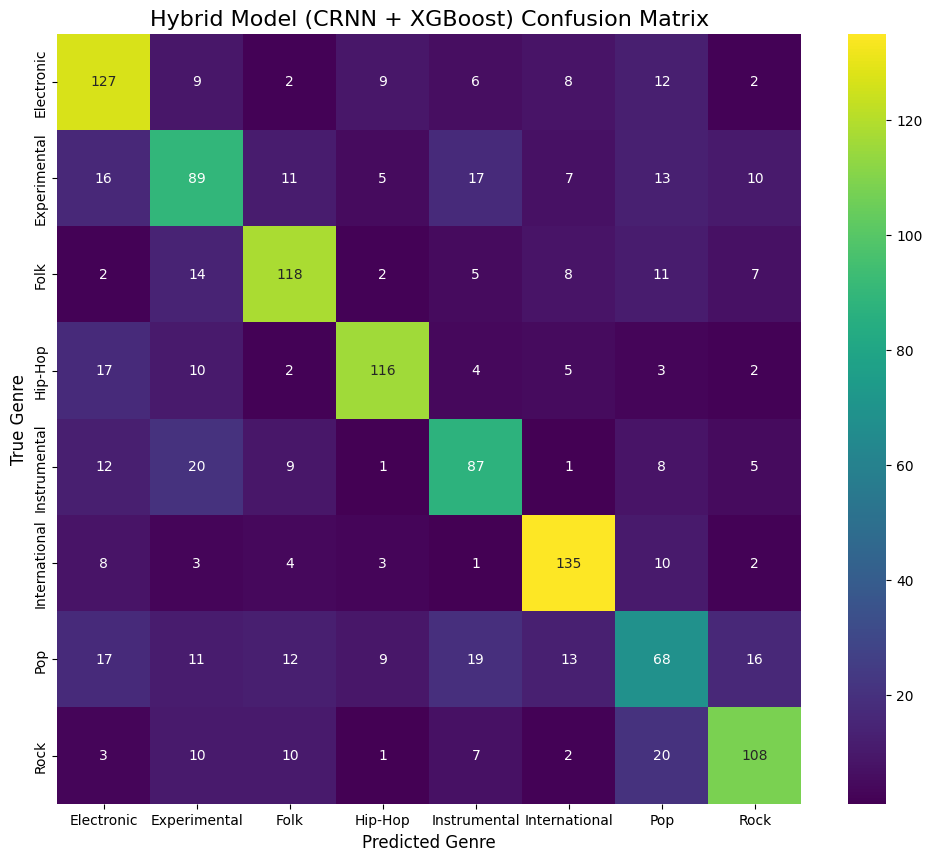

In [13]:
cm = confusion_matrix(y_test_deep_features, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=le.classes_, yticklabels=le.classes_)

plt.title('Hybrid Model (CRNN + XGBoost) Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Genre', fontsize=12)
plt.ylabel('True Genre', fontsize=12)
plt.show()